<H1>Truncated normal fit</H1>

In [3]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

import numpy as np
import os.path
import sys
import re
import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as npr
import numpy.ma as ma
from scipy.stats import norm

In [2]:
# Tabel interpolatie
def interpolate(xx,yy,x,default=np.nan,fraction=-1):
    if x<xx[0] or x>xx[-1]:
        return default
    for i in range(len(xx)-1):
        if (x>=xx[i] and x<=xx[i+1]):
            if fraction<0.0:
                w=(x-xx[i])/(xx[i+1]-xx[i])   # use fraction=0.0 for yy[i] and fraction=1.0 for yy[i+1]
            else:
                w=fraction
            return (1.-w)*yy[i] + w*yy[i+1]
        
def linfit(xvec, yvec, wvec=None):
    if wvec is None:
        w = np.ones(len(xvec))
    else:
        w = wvec
    sw = ma.sum(w)
    sx = ma.sum(w*xvec)
    sy = ma.sum(w*yvec)
    sxx = ma.sum(w*xvec*xvec)
    sxy = ma.sum(w*xvec*yvec)
    a = (sxy-sy*sx/sw)/(sxx-sx*sx/sw)
    b = (sy-a*sx)/sw
    return a,b

# LOESS smoother with a fixed width
def loess(x,y,xtgt,width,pwr=2.0):
    xmax=np.max(x)
    xmin=np.min(x)
    ytgt = np.array([])
    dydx = np.array([])
    for xx in xtgt:
        xxp = max(min(xx,xmax),xmin)
        mask = np.where(np.abs(x-xxp)<width)
        xsub = x[mask] - xxp
        ysub = y[mask]
        weights = (1.-(np.abs(xsub)/width)**pwr)**pwr
        a,b = linfit(xsub,ysub,weights)
        ytgt = np.append(ytgt,a*(xx-xxp) + b)
        dydx = np.append(dydx,a)
    return ytgt, dydx

# LOESS smoother with a fixed number of points
def loess_npt(x,y,npt=10,pwr=2.0):
    xmax=np.max(x)
    xmin=np.min(x)
    ytgt = np.array([])
    dydx = np.array([])
    n=len(x)
    for i in range(len(x)):
        xx = x[i]
        i0 = min(max(i-npt,0),n-2*npt-1)
        i1 = min(max(i+npt,2*npt),n-1)
        xsub = x[i0:i1] - xx    # shift relative to the origin of the local fit
        ysub = y[i0:i1]
        width = np.max(np.abs(xsub))
        weights = (1.-(np.abs(xsub)/width)**pwr)**pwr
        a,b = linfit(xsub,ysub,weights)
        ytgt = np.append(ytgt,b)
        dydx = np.append(dydx,a)
    return ytgt, dydx

In [70]:
def maxsimple2Db(x0, y0, x1, y1, fun, abstolx, abstoly):
    niter = 0
    maxiter = 100
    Lx = x1-x0
    Ly = y1-y0
    while (((Lx > abstolx) or (Ly > abstoly)) and (niter<maxiter)):
        niter = niter + 1
        f_lowest = np.nan
        for i in [-1,1]:                     # bepaal de laagste functiewaarde voor de centra van 4 kwadranten
            for j in [-1,1]:                 # xpt en ypt zijn de coordinaten van dat punt
                xpt = x0+Lx/2.+i*Lx/4.
                ypt = y0+Ly/2.+j*Ly/4.
                ftest = fun(xpt, ypt)
                if not(ftest>f_lowest):
                    newp = [i,j]
                    f_lowest = ftest
                    xpt_lowest = xpt
                    ypt_lowest = ypt
        if newp[0]>0:
            x1 = xpt_lowest
        else:
            x0 = xpt_lowest
        if newp[1]>0:
            y1 = ypt_lowest
        else:
            y0 = ypt_lowest
        Lx = x1-x0
        Ly = y1-y0
        print (x0,x1,y0,y1)
    return (x1+x0)/2., (y1+y0)/2.                   

In [71]:
# maximization in 1D the stupid way ....
def maxsimple1D(x0,x1,fun,abstol):
    phi = (1.+5.**0.5)/2. # golden:
    x = np.array([x0,x0+(x1-x0)/(1.+phi),x1])
    y = fun(x)            # must a vectorized function

    while (x[2]-x[0])>abstol:
        # insert new point (x,y)
        if (x[2]-x[1])>(x[1]-x[0]):
            newx = x[1] + (x[2]-x[1])/(1.+phi)
            x = np.insert(x,2,newx)
            y = np.insert(y,2,fun(newx))
        else:
            newx = x[1] - (x[1]-x[0])/(1.+phi)
            x = np.insert(x,1,newx)
            y = np.insert(y,1,fun(newx))

        # The choice is now between points 1 and 2 (the two in the middle)
        if y[1]>y[2]:       # take the first part
            x = x[:-1]
            y = y[:-1]
        else:               # take the last part
            x = x[1:]
            y = y[1:]
    return (x[2]+x[0])/2.

In [72]:
def funfun(x,y):
    return (-(2*x-3)**2-(3*y-2)**2)

maxsimple2Db(0., 0., 5., 5., funfun, 0.001, 0.001)

0.0 3.75 0.0 3.75
0.0 2.8125 0.0 2.8125
0.703125 2.8125 0.0 2.109375
0.703125 2.28515625 0.0 1.58203125
1.0986328125 2.28515625 0.0 1.1865234375
1.0986328125 1.988525390625 0.296630859375 1.1865234375
1.0986328125 1.76605224609375 0.296630859375 0.96405029296875
1.2654876708984375 1.76605224609375 0.4634857177734375 0.96405029296875
1.2654876708984375 1.6409111022949219 0.4634857177734375 0.8389091491699219
1.3593435287475586 1.6409111022949219 0.5573415756225586 0.8389091491699219
1.3593435287475586 1.570519208908081 0.5573415756225586 0.768517255783081
1.4121374487876892 1.570519208908081 0.6101354956626892 0.768517255783081
1.4517328888177872 1.570519208908081 0.6101354956626892 0.7289218157529831
1.4517328888177872 1.5408226288855076 0.6101354956626892 0.6992252357304096
1.4740053238347173 1.5408226288855076 0.6324079306796193 0.6992252357304096
1.4740053238347173 1.52411830262281 0.6491122569423169 0.6992252357304096
1.4865335685317405 1.52411830262281 0.6491122569423169 0.6866969

(1.4999827187412258, 0.6665527231341308)

<H2>Maximum-likelyhood $\sigma$</H2>
Likelyhood function for set $\left\lbrace x_i \right\rbrace$:

$$
{\cal L}\,=\,
\left[
\frac 1 {\Phi(a;\sigma)-\Phi(b;\sigma)}\frac 1 {\sigma\sqrt{2\pi}}
\right]^n\,\,
\prod\limits_{i}
\exp\left(\frac{\left(x_i-\mu\right)^2}{2\sigma^2}\right)
$$

$$
{\log(\cal L)}\,=\,
-n\log\left(\Phi(a;\sigma)-\Phi(b;\sigma)\right)\,-\,n\log(\sigma)\,-\,\frac n 2 \log(2\pi)\,-\,
\sum\limits_{i}
\frac{\left(x_i-\mu\right)^2}{2\sigma^2}
$$

$$
\cal Q(\mu,\sigma)\,\equiv\,
-n\log\left(\Phi(a;\mu,\sigma)-\Phi(b;\mu,\sigma)\right)\,-\,n\log(\sigma)\,-\,
\sum\limits_{i}
\frac{\left(x_i-\mu\right)^2}{2\sigma^2}
$$


...to be maximized by varying $\sigma$ and $\mu$, assuming that $a$ and $b$ are known. $\Phi$ is the normal cdf for the constant $\mu$ and the value of $\sigma$.

In [73]:
# likelyhood function of the truncated normal
def truncNormLfn(x,par):
    a = par['a']
    b = par['b']
    mu = par['mu']
    sigma = par['sigma']
    n = len(x)
    q = -n*np.log(norm.cdf((b-mu)/sigma)-norm.cdf((a-mu)/sigma)) - n*np.log(sigma) - np.sum((x-mu)**2)/(2.*sigma**2)
    return q

# truncated normal log-likelyhood function 
# with a given fixed (global) population, fixed (global) value of mu and varying sigma
def truncNormLfnSigma(s):
    return truncNormLfn(populatie,{'mu':mu_fixed, 'sigma':s, 'a':LowerLimit, 'b':UpperLimit})

def truncNormLfnMuSigma(u,s):
    return truncNormLfn(populatie,{'mu':u, 'sigma':s, 'a':LowerLimit, 'b':UpperLimit})

def truncNormMLSigma(xx, mu, lb, ub):
    global populatie, mu_fixed, LowerLimit, UpperLimit
    populatie = xx
    mu_fixed = mu
    LowerLimit = lb
    UpperLimit = ub
    xxstd = np.std(xx)
    sigma_res = maxsimple1D(xxstd,2*xxstd,np.vectorize(truncNormLfnSigma),0.01*xxstd)
    return sigma_res

def truncNormML(xx, lb, ub):
    global populatie, mu_fixed, LowerLimit, UpperLimit
    populatie = xx
    LowerLimit = lb
    UpperLimit = ub
    xxstd = np.std(xx)
    
    u = np.linspace(lb, ub, 30)
    s = np.linspace(xxstd*0.5, 2.0*xxstd, 30)
    U, S = np.meshgrid(u, s)
    Z = np.vectorize(truncNormLfnMuSigma)(U,S)
    fig, ax = plt.subplots()
    CS = ax.contour(U, S, Z)
    
    res = maxsimple2Db(lb,0.5*xxstd,ub,2*xxstd,truncNormLfnMuSigma,0.01*(ub-lb),0.01*xxstd)
    return res

def fitNormal(x, LowerBound, UpperBound):
    xx = np.sort(x[np.logical_and(x>LowerBound,x<UpperBound)])
    n = len(xx)
#   ff = (np.arange(1,n+1)-0.3)/(n+0.4)
    ff = (np.arange(1,n+1)-0.5)/(n)
    cdf, pdf = loess_npt(xx,ff,npt=100,pwr=2.0)
    maxloc = np.nanargmax(pdf)
    xmu = xx[maxloc]                      # the x with max density, associated with 'mu'
    print (xmu)
    
    sigma = truncNormMLSigma(xx, xmu, -100., 100)    
    return(xmu, sigma) 

2.4043859723259886 0.5985623147588325
-6.25 5 0.5237420254139784 1.197124629517665
-3.4375 5 0.6920876764399 1.197124629517665
-1.328125 5 0.8183469147093412 1.197124629517665
0.25390625 5 0.9130413434114222 1.197124629517665
0.25390625 3.8134765625 0.9840621649379828 1.197124629517665
1.143798828125 3.8134765625 1.0373277810829034 1.197124629517665
1.143798828125 3.14605712890625 1.0373277810829034 1.1571754174089746
1.6443634033203125 3.14605712890625 1.0373277810829034 1.1272135083274568
2.019786834716797 3.14605712890625 1.0373277810829034 1.1047420765163185
2.019786834716797 2.8644895553588867 1.0373277810829034 1.0878885026579648
2.019786834716797 2.6533138751983643 1.0373277810829034 1.0752483222641995
2.1781685948371887 2.6533138751983643 1.0373277810829034 1.0657681869688755
2.2969549149274826 2.6533138751983643 1.0373277810829034 1.0586580854973824
2.2969549149274826 2.564224135130644 1.0373277810829034 1.0533255093937626
2.2969549149274826 2.4974068300798535 1.03732778108290

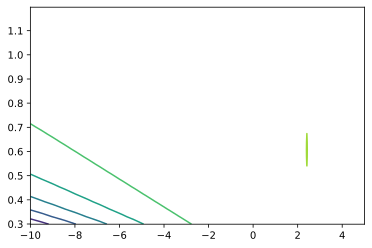

In [74]:
ss=np.random.normal(2.4,0.6,1000)
print (np.mean(ss),np.std(ss))
res = truncNormML(ss,-10,5)
print(res)


In [120]:
def fitNormal(x, LowerBound, UpperBound):
    xx = np.sort(x[np.logical_and(x>LowerBound,x<UpperBound)])
    n = len(xx)
#   ff = (np.arange(1,n+1)-0.3)/(n+0.4)
    ff = (np.arange(1,n+1)-0.5)/(n)
    cdf, pdf = loess_npt(xx,ff,npt=500,pwr=2.0)
    maxloc = np.nanargmax(pdf)
    xmu = xx[maxloc]                      # the x with max density, associated with 'mu'
    fmu = pdf[maxloc]                     # the max density
    sigma = truncNormMLSigma(xx, xmu, -100., 100)    
    return(mu, sigma) 

In [122]:
fitNormal(ss, -100,100)

1.4980405057118533 5.992162022847413


(6.0, 3.0082610076563707)

In [6]:
np.linspace(1,10,30)

array([ 1.        ,  1.31034483,  1.62068966,  1.93103448,  2.24137931,
        2.55172414,  2.86206897,  3.17241379,  3.48275862,  3.79310345,
        4.10344828,  4.4137931 ,  4.72413793,  5.03448276,  5.34482759,
        5.65517241,  5.96551724,  6.27586207,  6.5862069 ,  6.89655172,
        7.20689655,  7.51724138,  7.82758621,  8.13793103,  8.44827586,
        8.75862069,  9.06896552,  9.37931034,  9.68965517, 10.        ])

Text(0.5, 1.0, 'Simplest default with labels')

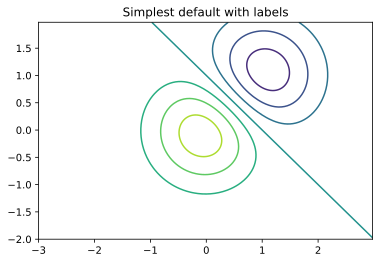

In [5]:
u = np.linspace(lb, ub, 30)
s = np.linspace(xxstd, 2.0*xxstd, 30)
U, S = np.meshgrid(u, s)
Z = truncNormLfnMuSigma(U,S)
fig, ax = plt.subplots()
CS = ax.contour(U, S, Z)
